# CosmoGrid Comparison

CosmoGrid is a large suite of N-body simulations spanning a wide range of cosmological parameters. This notebook validates our PM pipeline by comparing convergence maps and power spectra against CosmoGrid reference data.

The comparison tests whether our fast PM approximation reproduces the structure seen in full N-body simulations at the power spectrum level.

## Setup

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.97"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import jax_fli as jfli
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
from jax.sharding import AxisType, NamedSharding
from jax.sharding import PartitionSpec as P

assert (
    jax.device_count() == 4
), "This notebook is designed to run on 4 devices for demonstration purposes. Please adjust the code if you have a different number of devices."

jax.config.update("jax_enable_x64", False)

print(f"Number of devices: {jax.device_count()}")
print(f"Devices {jax.devices()}")
jax.print_environment_info()

mesh = jax.make_mesh((4, 1), ("x", "y"), axis_types=(AxisType.Auto, AxisType.Auto))
sharding = NamedSharding(mesh, P("x", "y"))

/lustre/fswork/projects/rech/tkc/commun/venv/pm/lib/python3.11/site-packages/jax/_src/compiler.py:783: UserWarning: Error reading persistent compilation cache entry for 'jit_convert_element_type': PermissionError: [Errno 13] Permission denied: '/jax_cache'
  warnings.warn(


Number of devices: 4
Devices [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
jax:    0.9.0.1
jaxlib: 0.9.0.1
numpy:  2.4.2
python: 3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]
device info: NVIDIA H100 80GB HBM3-4, 4 local devices"
process_count: 1
platform: uname_result(system='Linux', node='jzxh185', release='5.14.0-570.58.1.el9_6.x86_64', version='#1 SMP PREEMPT_DYNAMIC Tue Oct 21 04:15:07 EDT 2025', machine='x86_64')
JAX_PERSISTENT_CACHE_ENABLE_XLA_CACHES=xla_gpu_per_fusion_autotune_cache_dir
JAX_PERSISTENT_CACHE_MIN_ENTRY_SIZE_BYTES=-1
JAX_COMPILATION_CACHE_DIR=/jax_cache
JAX_PERSISTENT_CACHE_MIN_COMPILE_TIME_SECS=0
XLA_PYTHON_CLIENT_MEM_FRACTION=0.97

$ nvidia-smi
Wed Feb 18 14:27:02 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.16             Driver Version: 580.126.16     CUDA Version: 13.0     |
+-----------------------------------------+-----

## Load CosmoGrid Reference Data

`load_cosmogrid_lc` reads compressed HEALPix shells and the associated cosmology from a CosmoGrid simulation directory. The returned `Catalog` contains both the `SphericalDensity` lightcone and the `jc.Cosmology` used to run that simulation.

In [2]:
cosmogrid_path = "../../Simulations/CosmoGrid/raw/cosmo_000001/run_0/"
max_comoving_distance = 500.0

catalog = jfli.io.load_cosmogrid_lc(
    cosmogrid_path,
    max_comoving_distance=max_comoving_distance,
    ud_nside=512,
)
print(f"Loaded {catalog.field[0].shape[0]} shells")
cg_lightcone = catalog.field[0].to(jfli.units.DENSITY)[-4:]
cg_cosmo = catalog.cosmology[0]

print(f"CosmoGrid lightcone shape: {cg_lightcone.shape}")
print(f"CosmoGrid NSIDE: {cg_lightcone.nside}")
print(
    f"CosmoGrid cosmology: Omega_c={float(cg_cosmo.Omega_c):.4f}, h={float(cg_cosmo.h):.4f}, sigma8={float(cg_cosmo.sigma8):.4f}"
)

Loaded 13 shells
CosmoGrid lightcone shape: (4, 3145728)
CosmoGrid NSIDE: 512
CosmoGrid cosmology: Omega_c=0.2538, h=0.7300, sigma8=0.9000


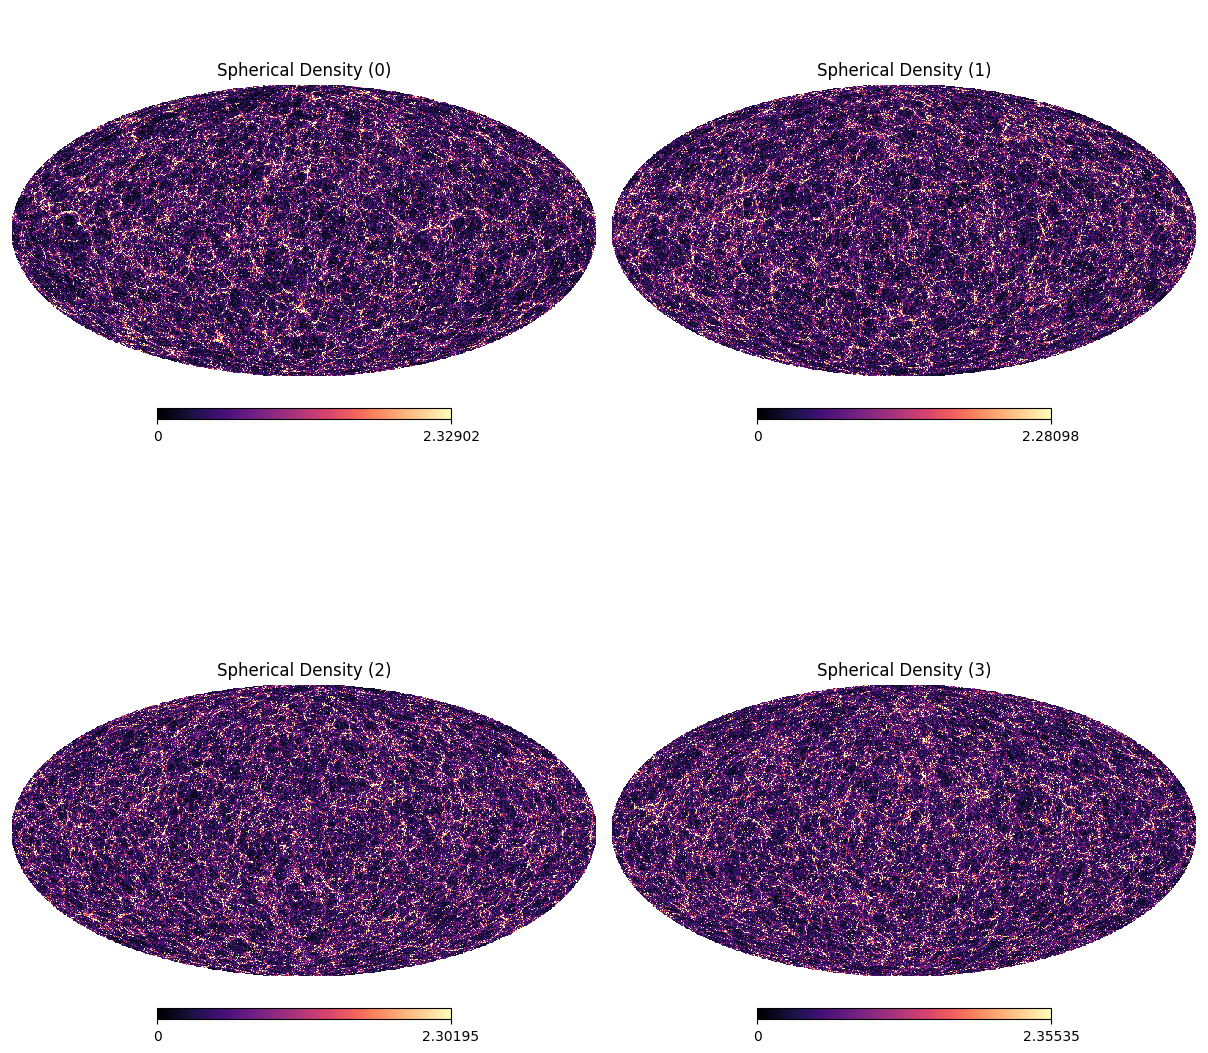

In [3]:
cg_lightcone[:4].show(ncols=2)

In [4]:
# Unload from memory
import numpy as np

bytes_used_before = jax.devices()[0].memory_stats()["bytes_in_use"]
cg_lightcone = cg_lightcone.apply_fn(np.array)
bytes_used_after = jax.devices()[0].memory_stats()["bytes_in_use"]

print(f"Memory used before unloading: {bytes_used_before / 1e9:.2f} GB")
print(f"Memory used after unloading: {bytes_used_after / 1e9:.2f} GB")

Memory used before unloading: 0.21 GB
Memory used after unloading: 0.16 GB


## Run Matching PM Simulation

To make a fair comparison, we run our PM pipeline with the same cosmology as the CosmoGrid simulation. The box size and shell structure are matched to the CosmoGrid output.

Matching PM config: box=500 Mpc/h, nside=1024, shells=4


W0218 14:27:41.792128  197405 hlo_rematerialization.cc:3204] Can't reduce memory use below 63.80GiB (68504088833 bytes) by rematerialization; only reduced to 68.83GiB (73905569175 bytes), down from 68.83GiB (73905569175 bytes) originally


PM lightcone shape: (4, 12582912)


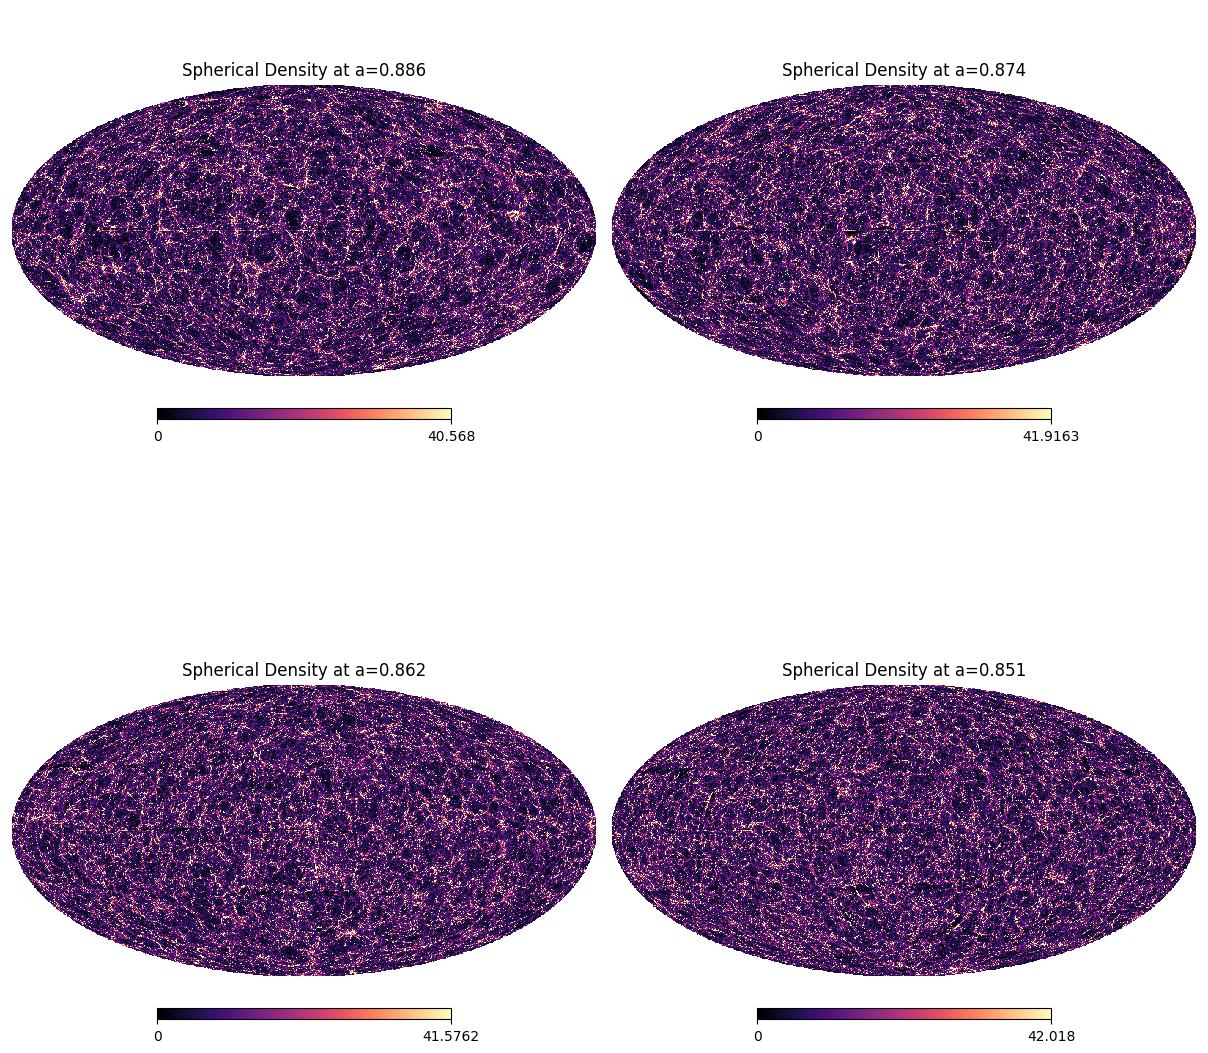

In [5]:
key = jax.random.PRNGKey(0)
mesh_size = (1200, 1200, 1200)
box_size = (500.0, 500.0, 500.0)  # Mpc/h
nside = 1024
nb_shells = cg_lightcone.shape[0]

print(f"Matching PM config: box={box_size[0]:.0f} Mpc/h, nside={nside}, shells={nb_shells}")

initial_field = jfli.gaussian_initial_conditions(
    key, mesh_size, box_size, cosmo=cg_cosmo, nside=nside, sharding=sharding
)

dx, p = jfli.lpt(cg_cosmo, initial_field, ts=0.1, order=1)

solver = jfli.ReversibleDoubleKickDrift(
    interp_kernel=jfli.OnionTiler(
        painting=jfli.PaintingOptions(target="spherical", scheme="bilinear"), drift_on_lightcone=False
    ),
)

pm_lightcone = jfli.nbody(
    cg_cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    ts=cg_lightcone.scale_factors.squeeze()[::-1].astype(
        jnp.float32
    ),  # Reverse the scale factors to match the lightcone order
    solver=solver,
)

print(f"PM lightcone shape: {pm_lightcone.shape}")
pm_lightcone[:4].show(ncols=2)

## Apply Lensing

Compute convergence maps for both the CosmoGrid and our PM lightcones using the Born approximation.

In [6]:
LMAX = 3 * 512
cl_me = ((pm_lightcone / pm_lightcone.mean(axis=-1, keepdims=True)) - 1).angular_cl(method="healpy", lmax=LMAX)
cl_cg = ((cg_lightcone / cg_lightcone.mean(axis=-1, keepdims=True)) - 1).angular_cl(method="healpy", lmax=LMAX)

r_center = pm_lightcone.comoving_centers
r_width = pm_lightcone.density_width
r_near, r_far = r_center - r_width / 2, r_center + r_width / 2
z_near, z_far = jc.utils.a2z(jc.background.a_of_chi(cg_cosmo, jnp.array([r_near, r_far])))

nz_s = [jfli.tophat_z(n, f, gals_per_arcmin2=1.0) for n, f in zip(z_near, z_far)]
ells = jnp.arange(LMAX)
theory_cl = jfli.compute_theory_cl(
    cg_cosmo,
    ell=ells,
    z_source=nz_s,
    probe_type="number_counts",
    nonlinear_fn="linear",
    cross=False,
)

ratio = cl_me / cl_cg

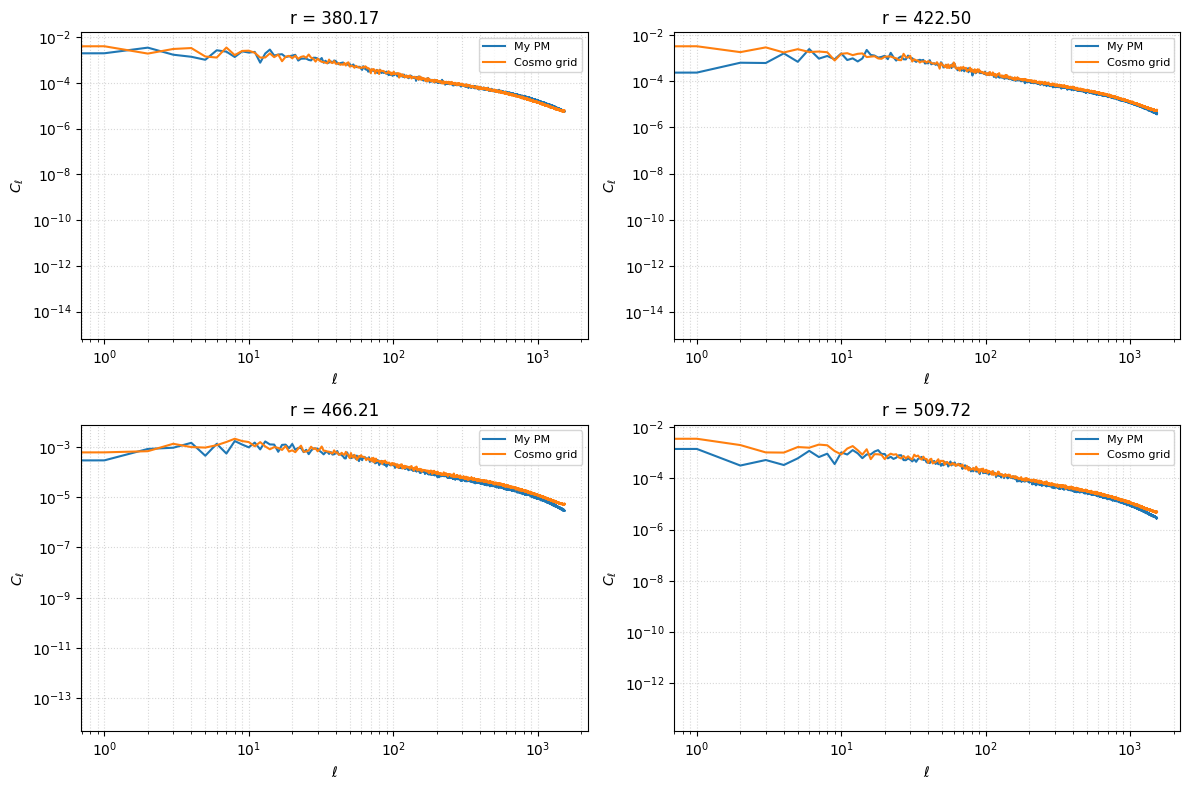

In [7]:
# Plot
ncols = 2
nrows = (nb_shells + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

for i in range(nb_shells):
    cl_me[i].plot(ax=axes[i], logx=True, logy=True, label="My PM")
    cl_cg[i].plot(ax=axes[i], logx=True, logy=True, label="Cosmo grid")
    axes[i].set_title(f"r = {float(r_center[i]):.2f}")
    axes[i].legend(fontsize=8)

for i in range(nb_shells, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

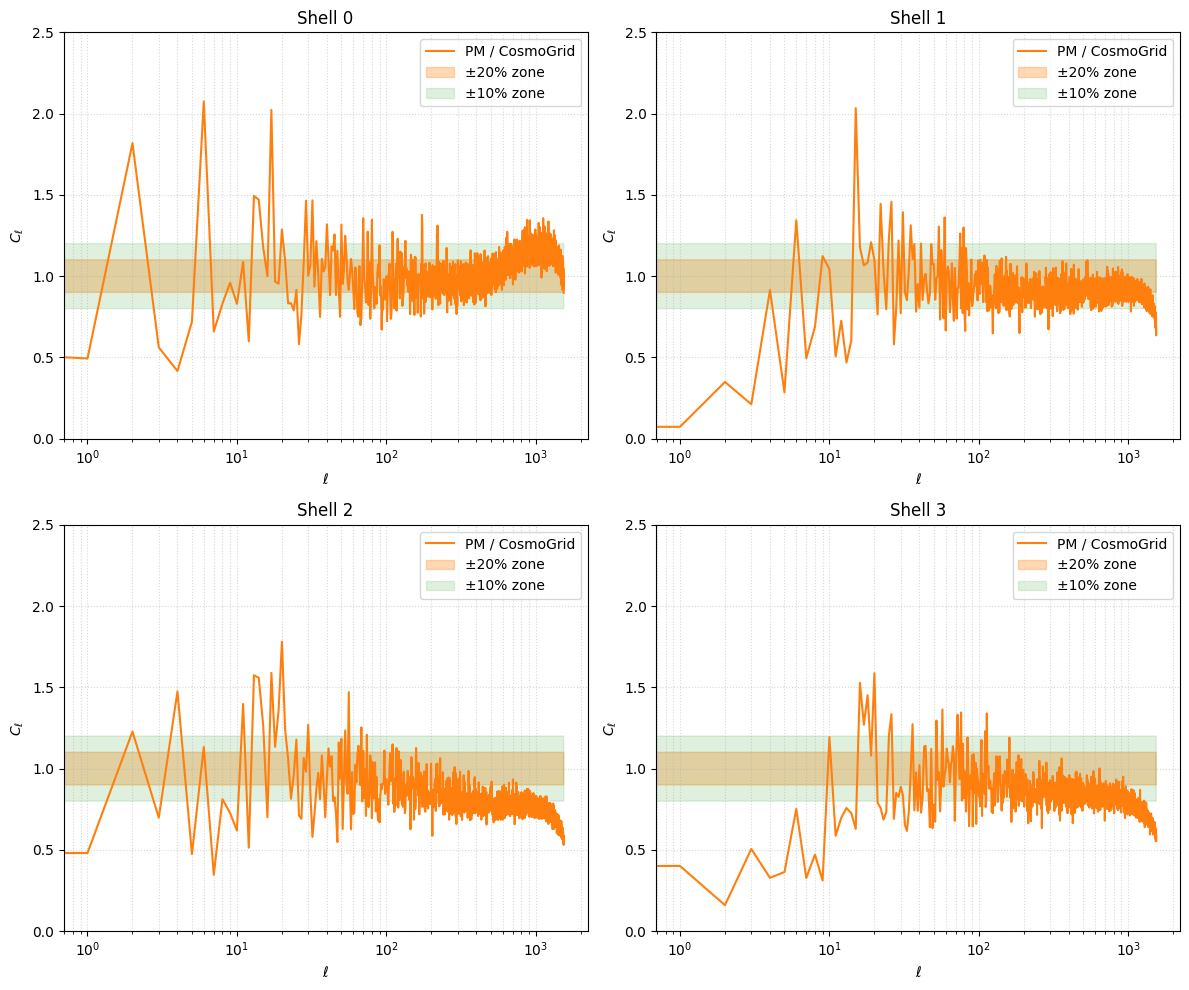

In [13]:
ncol = 2
nrow = (ratio.shape[0] + ncol - 1) // ncol
fig, ax = plt.subplots(nrow, ncol, figsize=(6 * ncol, 5 * nrow))
ax = ax.flatten()
for i in range(ratio.shape[0]):
    ratio[i].plot(ax=ax[i], logx=True, logy=False, label="PM / CosmoGrid", color="tab:orange")
    ax[i].set_title(f"Shell {i}")
    ax[i].fill_between(ratio[i].wavenumber, 0.9, 1.1, color="tab:orange", alpha=0.3, label="±20% zone")
    ax[i].fill_between(ratio[i].wavenumber, 0.8, 1.2, color="tab:green", alpha=0.15, label="±10% zone")
    ax[i].legend()
    ax[i].set_ylim(0.0, 2.5)

plt.tight_layout()
plt.show()

Number of tomographic bins: 2


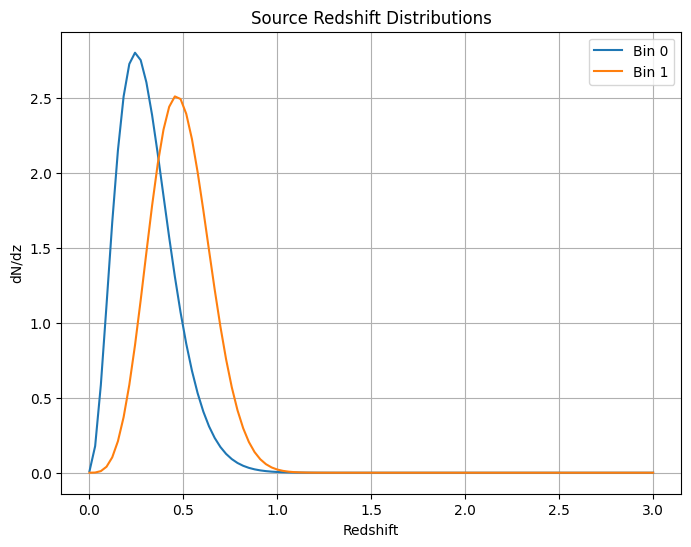

In [9]:
nz_sources = jfli.io.get_stage3_nz_shear()[:-2]  # The last bin is too far
print(f"Number of tomographic bins: {len(nz_sources)}")

z_bin = jnp.linspace(0.0, 3.0, 100)
figure = plt.figure(figsize=(8, 6))
for i, nz in enumerate(nz_sources):
    plt.plot(z_bin, nz(z_bin), label=f"Bin {i}")
plt.xlabel("Redshift")
plt.ylabel("dN/dz")
plt.title("Source Redshift Distributions")
plt.legend()
plt.grid()
plt.show()

In [10]:
kappa_cg = jfli.born(cg_cosmo, cg_lightcone, nz_shear=nz_sources)
kappa_pm = jfli.born(cg_cosmo, pm_lightcone, nz_shear=nz_sources)

print(f"CosmoGrid kappa shape: {kappa_cg.shape}")
print(f"PM kappa shape: {kappa_pm.shape}")

CosmoGrid kappa shape: (2, 3145728)
PM kappa shape: (2, 12582912)


## Compare Power Spectra

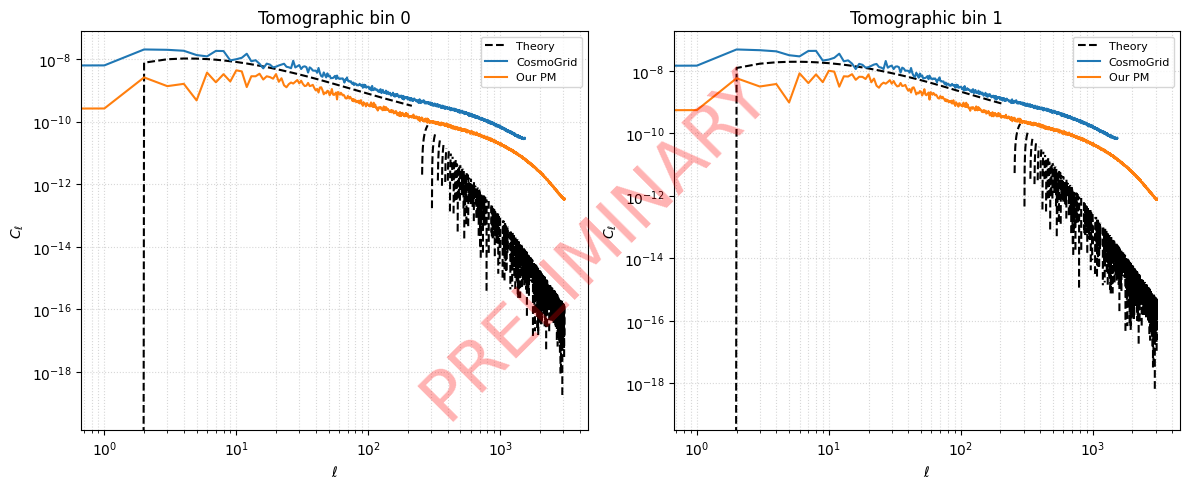

In [18]:
LMAX = 3 * nside
ells = jnp.arange(LMAX)

theory_cl = jfli.compute_theory_cl(
    cg_cosmo,
    ell=ells,
    z_source=nz_sources,
    probe_type="weak_lensing",
    nonlinear_fn=jc.power.halofit,
    cross=False,
)

cl_cg = kappa_cg.angular_cl(method="healpy")
cl_pm = kappa_pm.angular_cl(method="healpy")

n_bins = len(nz_sources)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Add the watermark
fig.text(0.5, 0.5, "PRELIMINARY", color="red", fontsize=50, ha="center", va="center", alpha=0.3, rotation=45)

axes = axes.flatten()

for i in range(n_bins):
    theory_cl[i].plot(ax=axes[i], logx=True, logy=True, label=["Theory"], color="black", linestyle="--")
    cl_cg[i].plot(ax=axes[i], logx=True, logy=True, label=["CosmoGrid"], color="tab:blue")
    cl_pm[i].plot(ax=axes[i], logx=True, logy=True, label=["Our PM"], color="tab:orange")
    axes[i].set_title(f"Tomographic bin {i}")
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.show()